#### Integrin
#### DMap and decoder

#### Reference notebook: ../cg_300_integrated_training_integrin_dmap.ipynb

## setup

In [1]:
import os
import sys
import math
import time
import pickle
import copy
#import mdtraj
import MDAnalysis as mda
#import pyemma
#import pyemma.util.contexts
import networkx as nx
import random
#import parmed as pmd
import acpype
import pandas as pd
from MDAnalysis.analysis import distances


import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import ticker
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#import torch
#import torch.optim as optim
#import torch.nn as nn
#from torchviz import make_dot
#from torch.utils.data import Dataset, TensorDataset, DataLoader
#from torch.utils.data.dataset import random_split
#from tqdm import tqdm

#import deeptime
#from deeptime.decomposition import TICA
#from deeptime.clustering import KMeans
##import mdshare

from sklearn.preprocessing import MinMaxScaler

from jax import numpy as jnp, jit, vmap
from MDAnalysis.analysis import rms #diffusionmap, align, rms

import nglview as nv


no display found. Using non-interactive Agg backend


In [2]:
#from lss.snrv.snrv import Snrv, load_snrv
#from molgen.molgen.models import WGANGP
import sys
from importlib import reload
sys.path.append('../../../')
from codes.dMap_JAX import dMap_jax, rmsd_jax
from codes.dMap_JAX import diff_plots
reload(diff_plots)

<module 'codes.dMap_JAX.diff_plots' from '/work2/03273/tg825722/shared-folder-siva/doe/analysis-integrin/integrin_dmap_gan_notebooks/MS_final_notebooks/../../../codes/dMap_JAX/diff_plots.py'>

In [4]:
!python3 --version

import os
#del os.environ['LD_LIBRARY_PATH']
#del os.environ['PATH']

!python3 --version

os.environ['LD_LIBRARY_PATH'] ="/opt/apps/cuda/11.3/lib64" + os.pathsep + os.environ["LD_LIBRARY_PATH"]
os.environ['PATH']="/opt/apps/xalt/xalt/bin:/opt/apps/cuda/11.3/bin" + os.pathsep + os.environ["PATH"]

!python3 --version


#import torch
!python3 ../../../archive/test.gpu


Python 3.9.15
Python 3.9.15
Python 3.9.15
True


#### plot settings

In [5]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

#### Load AA trajectories

In [11]:
universe_cg_traj_reps = []


for rep in ['bent', 'int1', 'int2', 'open']: #, '0d01_10',  '0d01_5']:

    file_cg_traj_bent = '../../../integrin/all-atom/cg_' + rep

    universe_cg_traj_reps.append( mda.Universe(file_cg_traj_bent + '.pdb', file_cg_traj_bent + '.xtc' ) )

#for rep in [2, 3, 4]:
#
#    file_cg_traj_break_legs_rep = 'integrin-data/grains_cg/inputs_lammps/break_legs/rep_'+str(rep)+ '/dump22'
#    
#    universe_cg_traj_reps.append( mda.Universe(file_cg_traj_break_legs_rep + '_mda.pdb', file_cg_traj_break_legs_rep + '_mda.xtc' ) )
#    
#for rep in [2, 3, 4]:
#    
#    file_cg_traj_no_break_rep = 'integrin-data/grains_cg/inputs_lammps/no_break/rep_'+str(rep)+ '/dump22'
#
#    universe_cg_traj_reps.append( mda.Universe(file_cg_traj_no_break_rep + '_mda.pdb', file_cg_traj_no_break_rep + '_mda.xtc' ) )
    

/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:300: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:301: RuntimeWarning: invalid value encountered in scalar divide
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:302: RuntimeWarning: invalid value encountered in scalar divide
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))


In [12]:
for i in range(len(universe_cg_traj_reps)):
    print(universe_cg_traj_reps[i].trajectory.n_frames)

4996
5893
5047
5172


### diffusion map

#### visualize trajs

In [9]:
import nglview as nv
import seaborn as sns

view = nv.show_mdanalysis(universe_cg_traj_reps[0])

# clear representations
view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=list(np.arange(169)), color='blue', radius=5, opacity=0.85)
view.add_representation('spacefill', selection=list(np.arange(169, 300)), color='red', radius=5)

#view.add_representation('spacefill', selection="index 100 to 299", color='red')

#view.component_1.add_surface(opacity=0.3)
#view.download_image()
#view.render_image(factor=6) # higher is better
# need to run below command in different notebook cell
#view._display_image()

view

/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:300: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:301: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:302: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))


NGLWidget(max_frame=4995)

#### catenate all trajectories

In [13]:
#### merge trajs
lag_n = 400
lag_n_aa = 2
Nframes=2450 #4800#2000
a2b_b3 = []
for i in range(4):
    _a2b_b3 = []
    for ts in universe_cg_traj_reps[i].trajectory:
        #print(ts.positions)
        _a2b_b3.append(ts.positions.copy())
    a2b_b3.append(np.array(_a2b_b3))
    
cat_trajs = np.concatenate(( a2b_b3[0][0::lag_n_aa][:Nframes],
                             a2b_b3[1][0::lag_n_aa][:Nframes],
                             a2b_b3[2][0::lag_n_aa][:Nframes],
                             a2b_b3[3][0::lag_n_aa][:Nframes] )) #,
                             #a2b_b3[4][1::lag_n][:667],
                             #a2b_b3[5][1::lag_n][:667],
                             #a2b_b3[6][1::lag_n][:666],
                             #a2b_b3[7][1::lag_n][:667],
                             #a2b_b3[8][1::lag_n][:667],
                             #a2b_b3[9][1::lag_n][:666])) # .shape
                        
#####cat_excl_trajs = np.concatenate(( a2b_b3[0][1::lag_n_aa][:Nframes],
#####                                 a2b_b3[1][1::lag_n_aa][:Nframes],
#####                                 a2b_b3[2][1::lag_n_aa][:Nframes],
#####                                 a2b_b3[3][1::lag_n_aa][:Nframes] )) #,
#####                             #a2b_b3[4][1::lag_n][:667],
#####                             #a2b_b3[5][1::lag_n][:667],
#####                             #a2b_b3[6][1::lag_n][:666],
#####                             #a2b_b3[7][1::lag_n][:667],
#####                             #a2b_b3[8][1::lag_n][:667],
#####                             #a2b_b3[9][1::lag_n][:666])) # .shape

#lag_n=100
#cat_trajs = np.concatenate(( np.array(universe_cg_traj_reps[0].trajectory[::lag_n]), 
#                             np.array(universe_cg_traj_reps[3].trajectory[::lag_n]) )) # .shape
#
#
#
#
#
#

In [8]:
#cat_trajs[-1]-cat_excl_trajs[-1]

In [14]:
print(cat_trajs.shape)
#print(cat_excl_trajs.shape)

for i in range(4):
    if i <4:
        sa=0
        la=2#lag_n_aa
    else:
        sa=1
        la=lag_n
    print(a2b_b3[i].shape)#[:2000]
        
   # print(a2b_b3[i][sa::la].shape)#[:2000]
    
    #print(np.array(universe_cg_traj_reps[i].trajectory[1::la]).shape)

(9800, 300, 3)
(4996, 300, 3)
(5893, 300, 3)
(5047, 300, 3)
(5172, 300, 3)


#### save cat and extended for external RMSD calculation


In [11]:
#with open('integrin_aa_cg_300_trajs/traj_sample_outofsample.pkl', "wb") as f:
#        pickle.dump({'cat_trajs': cat_trajs, 'cat_excl_trajs': cat_excl_trajs}, f)

#### calculate or load RMSD data

In [10]:
## calculate pairwise RMSD

#start = time.time()

#rmsd_jax.run_rmsd(jnp.array(cat_trajs), batch_ref_frame_size=100, nref_frames=cat_trajs.shape[0] + 1, output_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/init_aa_cg_data/integrin_pair_rmsd_")
#rmsd_jax.run_rmsd(jnp.array(cat_trajs), batch_ref_frame_size=100, nref_frames=cat_trajs.shape[0]//2 + 1, output_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/integrin_pair_rmsd_")

#print("RMSD calculations finished in {} seconds".format(time.time()-start))


#### out of sample RMSD with in sample RMSD

In [42]:

#start = time.time()
#
#rmsd_jax.run_rmsd(jnp.array(cat_trajs), 
#                  nref_frames=cat_trajs.shape[0] + 1, 
#                  batch_ref_frame_size=100, 
#                  output_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/init_aa_cg_data_outsample/integrin_pair_rmsd_", 
#                  device=None, traj2_jax_array=jnp.array(cat_excl_trajs))
#
#print("RMSD calculations finished in {} seconds".format(time.time()-start))


In [11]:
19960//2

9980

In [15]:
## load pairwise RMSD


sym_prmsd_jax = rmsd_jax.load_rmsd(nref_frames=cat_trajs.shape[0] + 1, 
                                   batch_ref_frame_size=100, 
                                   input_file_prefix="../../integrin_aa_cg_300_integrated_rmsd_data/init_aa_cg_data/integrin_pair_rmsd_", 
                                   tol=1e-5)
    
    
#in_sym_prmsd_jax = rmsd_jax.load_rmsd(nref_frames=cat_trajs.shape[0] + 1, 
#                                       batch_ref_frame_size=100, 
#                                       sym=False,
#                                       input_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/init_aa_cg_data_insample/integrin_pair_rmsd_", 
#                                       tol=1e-5)

## load pairwise RMSD


#out_sym_prmsd_jax = rmsd_jax.load_rmsd(nref_frames=cat_trajs.shape[0] + 1, 
#                                       batch_ref_frame_size=100, 
#                                       sym=False,
#                                       input_file_prefix="../../integrin_aa_cg_300_integrated_rmsd_data/init_aa_cg_data_outsample/integrin_pair_rmsd_", 
#                                       tol=1e-5)
#    

    

Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 


In [16]:
sym_prmsd_jax_nm = sym_prmsd_jax/10
####out_sym_prmsd_jax_nm = out_sym_prmsd_jax/10

#in_sym_prmsd_jax_nm = in_sym_prmsd_jax/10

In [17]:
#sym_prmsd_jax_nm[10] - out_sym_prmsd_jax_nm[10]

In [18]:
#(sym_prmsd_jax_nm-prmsd_jax_nm).max()
print(sym_prmsd_jax_nm[8000:,8000:].max())
sym_prmsd_jax_nm[8000:,8000:].argmax(0)

2.6734462


Array([ 730, 1506, 1506, ...,   11,   11,   11], dtype=int32)

In [19]:
sym_prmsd_jax_nm[8000:,8000:][4274].max()

Array(2.25208, dtype=float32)

#### plot full RMSD (all trajectories)

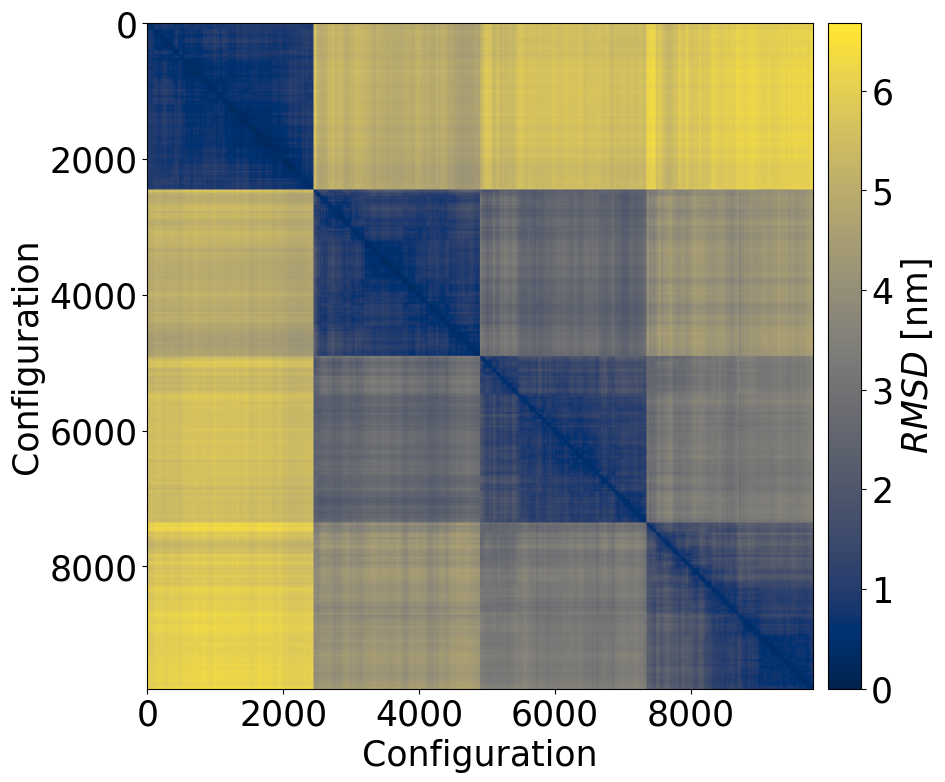

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,1, figsize = (10,10))
#axes = axes.flatten()

#im1 = axes.imshow(sym_prmsd_jax_nm[0:2000,0:2000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[2000:4000,2000:4000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[4000:6000,4000:6000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[6000:8000,6000:8000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:11000,8000:11000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[11000:14000,11000:14000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:14000,8000:14000], cmap='viridis', vmin=0)
#axes.scatter(4274, 723, s=50, c='yellow')

im1 = axes.imshow(sym_prmsd_jax_nm[::1,::1], cmap='cividis', vmin=0)


axes.set_xlabel('Configuration')
axes.set_ylabel('Configuration')


#axes.set_xticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))
#axes.set_yticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im1, cax=cax, orientation='vertical', label='$RMSD$ [nm]')


fig.tight_layout()    
#fig.savefig('jax-rmsd-integrin-full.png',dpi=150)

In [16]:
### PCA

In [19]:
#sym_prmsd_jax_nm = sym_prmsd_jax_nm[:2000, :2000]

In [20]:
#from sklearn.decomposition import PCA
#pca = PCA() #n_components=)
#pca.fit(sym_prmsd_jax_nm)


In [21]:
#X_transformed = pca.transform(sym_prmsd_jax_nm)

In [22]:
#pca.explained_variance_ratio_

In [23]:
#plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [24]:
#plt.figure(figsize=(10, 7))
#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4]
#plt.scatter(x=X_transformed[:, 0], y=X_transformed[:, 1], c=colors)
#

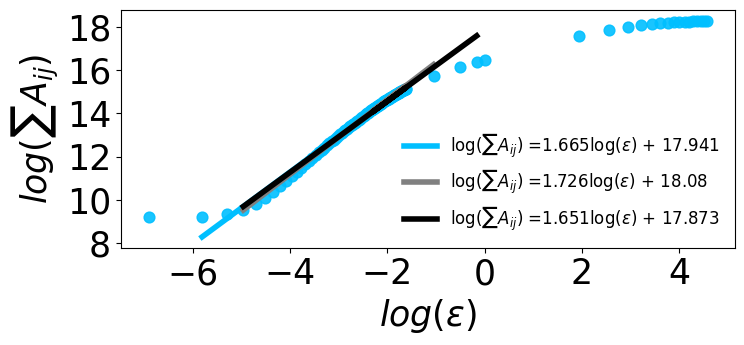

In [33]:
#### generate a range of epsilon

epsilon = jnp.concatenate(( jnp.arange(0.001,0.2,.002), jnp.arange(0.1,1,.25), jnp.arange(1,100,6) ))

#print(epsilon)

sum_A = []
for e in epsilon:
    #A = jnp.exp(-jnp.square(sym_prmsd_jax_nm[:2000,:2000])/(2*e))
    A = jnp.exp(-jnp.square(sym_prmsd_jax_nm)/(2*e))
    
    sum_A.append(A.sum())
    
    
    
fig, axes = plt.subplots(1, 1, figsize = (8,4))

plt.scatter(np.log(epsilon), np.log(sum_A), alpha=0.9, color='deepskyblue',s=60)

#plt.yscale('log')
#plt.xscale('log')

#plt.ylim(0,1e5)
plt.xlabel(r'$log(\epsilon)$') #[nm$^{2}$]
plt.ylabel(r'$log(\sum A_{ij})$')


def linear_fit(x, a, b):
    return a*x + b

from scipy.optimize import curve_fit

### case 1
e2_1 = np.log(epsilon)[np.log(epsilon)>-6]
a2_1 = np.log(sum_A)[np.log(epsilon)>-6]
a2_1 = a2_1[e2_1<-1]
e2_1 = e2_1[e2_1<-1]

### case 2
e2_2 = np.log(epsilon)[np.log(epsilon)>-5]
a2_2 = np.log(sum_A)[np.log(epsilon)>-5]
a2_2 = a2_2[e2_2<-1]
e2_2 = e2_2[e2_2<-1]

### case 3
e2_3 = np.log(epsilon)[np.log(epsilon)>-5.]
a2_3 = np.log(sum_A)[np.log(epsilon)>-5.]
a2_3 = a2_3[e2_3<0]
e2_3 = e2_3[e2_3<0]

popt_1, _ = curve_fit(linear_fit, e2_1, a2_1, p0=(1,0))
popt_2, _ = curve_fit(linear_fit, e2_2, a2_2, p0=(1,0))
popt_3, _ = curve_fit(linear_fit, e2_3, a2_3, p0=(1,0))


plt.plot(e2_1, linear_fit(e2_1, popt_1[0], popt_1[1]), color="deepskyblue", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_1[0],3))+'log($\epsilon$) + '+str(round(popt_1[1],3)))
plt.plot(e2_2, linear_fit(e2_2, popt_2[0], popt_2[1]), color="gray", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_2[0],3))+'log($\epsilon$) + '+str(round(popt_2[1],3)))
plt.plot(e2_3, linear_fit(e2_3, popt_3[0], popt_3[1]), color="black", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_3[0],3))+'log($\epsilon$) + '+str(round(popt_3[1],3)))

#scipy.optimize.curve_fit(func, x, y)

plt.legend(fontsize=12,frameon=False)
plt.locator_params(axis='both', nbins=10)

#plt.title(r'ref frame: {0}'.format(ref_i), fontsize=32)

fig.tight_layout()
#fig.savefig('epsilon-integrin-A.png',dpi=150)


#### set dMap parameters

In [15]:
log_selected_e = 3.982
print(log_selected_e)
selected_e = np.exp(log_selected_e)
print(selected_e)

alpha=0.1
print(alpha)

3.982
53.62417540140635
0.1


#### run dMap

In [24]:


start = time.time()
print(f"eps is set to {selected_e} and alpha is set to {alpha}".format(selected_e))
lamb, psi = dMap_jax.diffMaps(selected_e, sym_prmsd_jax_nm, alpha=alpha,
                               jit_compile=False, check_pos_definite=True, tol=-1e-9)
print("JAX dMap calculations finished in {} seconds".format(time.time()-start)) 

#start = time.time()
#lamb_np, psi_np = dMap_jax.diffMaps_Numpy(selected_e, sym_prmsd_jax_nm, alpha=0.5)
#print("Numpy dMap calculations finished in {} seconds".format(time.time()-start)) 


eps is set to 53.62417540140635 and alpha is set to 0.1
Applying adaptive density diffusion map using alpha:0.1
JAX dMap calculations finished in 34.44352078437805 seconds


In [28]:
#### save dMap
with open("evecs_evals_integrin_aa_cg_300.pkl", 'wb') as f:
        pickle.dump({'lamb': np.array(lamb),
                     'psi': np.array(psi)}
                    , f)

In [6]:
#### load dMap

with open(r"../../../analysis-integrin/gan_saved_models/evecs_evals_integrin_aa_cg_300.pkl", "rb") as input_file:
    dMaps_saved = pickle.load(input_file)

lamb = dMaps_saved['lamb']
psi = dMaps_saved['psi']

In [20]:
#b = psi[:,0]#.shape
#print(psi.shape)
#print(b.shape)
#a = out_sym_prmsd_jax_nm#.shape
#print(a.shape)
#c = a*b
#(c).shape
#print(b)
#print(a[0])
#print(c[0].sum())
#print(c.sum(axis=1)) #.shape)
#print(lamb[0])
##print(c[0])
##print(0.00010264*0.20620747)
##print(0.00010264*0.21813421)
##print(0.00010264*0.26551375)

#### run Nystrom extension on out-of-sample dataset

In [37]:
####
####start = time.time()
####print(f"eps is set to {selected_e} and alpha is set to {alpha}".format(selected_e))
####t_psi_new = dMap_jax.nystrom_jax(selected_e, out_sym_prmsd_jax_nm, lamb, psi, 
####                               alpha=alpha, jit_compile=True, device=None)
####print("JAX dMap calculations finished in {} seconds".format(time.time()-start)) 
####

In [42]:
alpha

0.1

In [38]:
######## save nystrom extension out-of-sample psi and lamb
####psi_updated = np.concatenate((psi, t_psi_new))
####with open("evecs_evals_nystrom_integrin_aa_cg_300.pkl", 'wb') as f:
####        pickle.dump({'lamb': np.array(lamb),
####                     'psi': np.array(psi_updated)}
####                    , f)

In [56]:
#diff_plots.plotmaps(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap='deepskyblue', cmap='None', colorbar=False, skip_3D=False, figSuffix = 'singlecolor_opt1')


In [12]:
#c=0
#for e in list(np.arange(np.exp(-4.5), np.exp(log_selected_e), 0.2)):
#
#    print(c, e)
#    diff_plots.plotspect(lamb_e[c][:20], e, skip_lead=True, figSuffix='')
#    
#    c+=1
#


#### eigenvalue spectrum

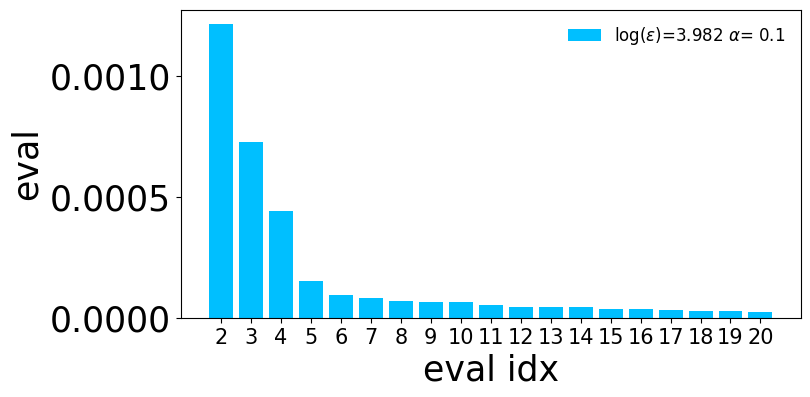

In [15]:
%matplotlib inline
diff_plots.plotspect(lamb[:20], log_selected_e, alpha, skip_lead=True, figSuffix='_opt1')
#diff_plots.plotspect(lamb[-20:], selected_e, skip_lead=True, figSuffix='trail_opt1')

In [31]:
#diff_plots.plotspect(lamb_np[-20:], selected_e, skip_lead=True, figSuffix='_opt1')

In [28]:
#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3,
#          np.ones(2450)*4]#, np.ones(2000)*5, np.ones(2000)*6]
##colors = [np.ones(2000)*1]
#
#lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange']) #'red', 'black'
#        .with_extremes(over='0.25', under='0.75'))
#
#diff_plots.plotmaps(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], 
#                    skip_lead=True, colorMap=colors, cmap=lcmap, colorbar=True, 
#                    colorlabel='Model', skip_3D=False, figSuffix = 'colorbymodel_opt1')
#

#### dMaps

nplots_split:3
7


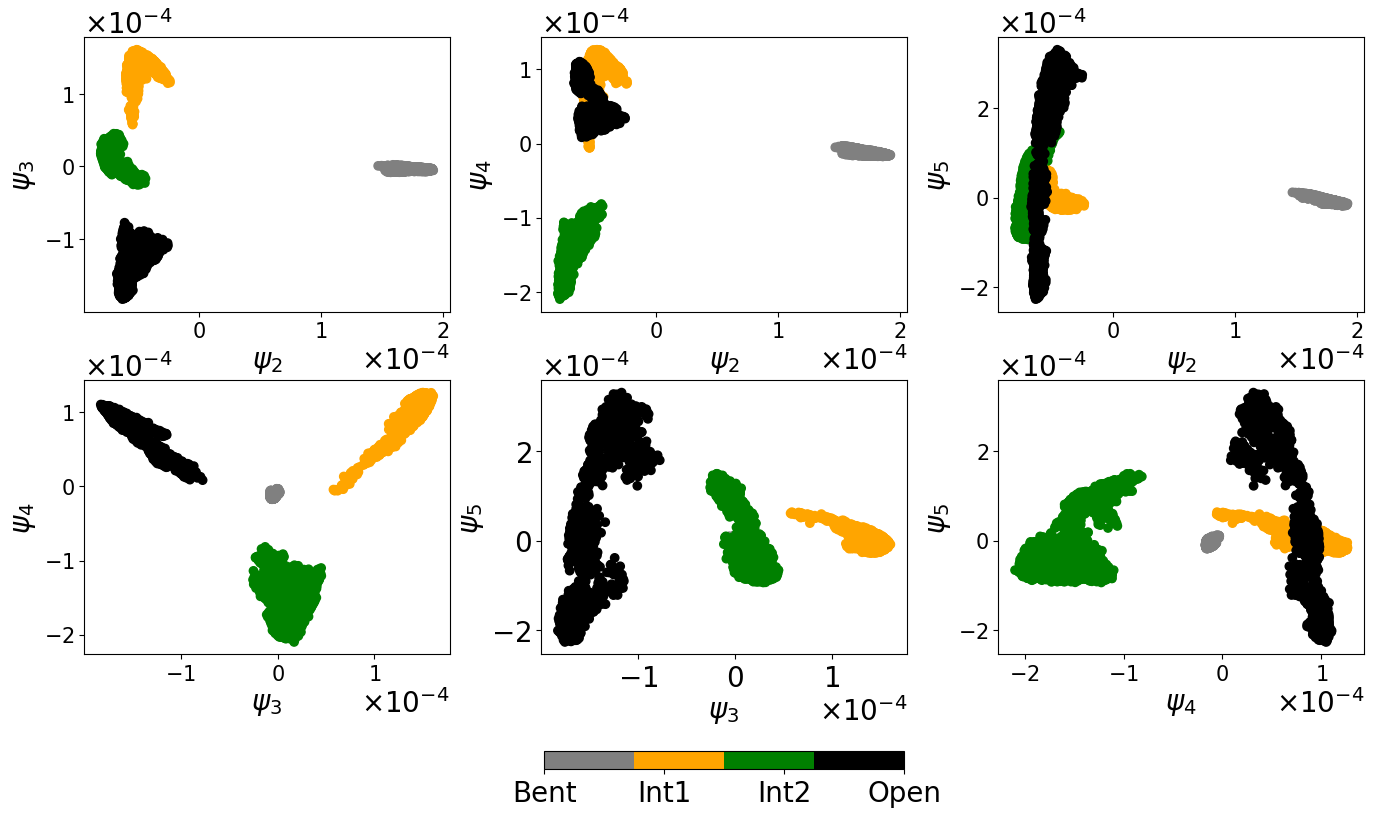

/work2/03273/tg825722/shared-folder-siva/doe/integrin_dmap_gan_notebooks/MS_final_notebooks/../../codes/dMap_JAX/diff_plots.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0, 0))


In [102]:
#### projections along top 4 dimensions
#colors = [np.ones(2000)*1, np.ones(2000)*1, np.ones(2000)*1,
#          np.ones(2000)*2, np.ones(2000)*2, np.ones(2000)*2]
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3,
          np.ones(2450)*4]

lcmap = (mpl.colors.ListedColormap(['gray', 'orange', 'green', 'black'])
        .with_extremes(over='0.25', under='0.75'))


diff_plots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                      skip_lead=True, colorMap=colors, cmap=lcmap, ticks=[1,2,3,4], 
                      colorbar=True, colorlabel='', figSuffix='2d_opt1', 
                      cticklabels=['Bent', 'Int1', 'Int2', 'Open'], singlecolorbar=True)


#### Nystrom extension (out-of-sample points)

In [26]:
#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4, 
#          np.ones(2450)*5, np.ones(2450)*6, np.ones(2450)*7, np.ones(2450)*8]
#
#colors = np.concatenate(colors, axis=0)#[::200]
#
#lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 
#                                    'orange', 'gray', 'yellow', 'red', 
#                                    'black']).with_extremes(over='0.25', under='0.75'))
#
#diff_plots.plotmaps(np.concatenate((psi, t_psi_new)), selected_e, plot_stride=1, 
#                    select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, 
#                    cmap=lcmap, colorbar=True, colorlabel='Model', skip_3D=False, 
#                    figSuffix = 'colorbymodel_outsample_opt1')
#

In [27]:
##### projections along top 4 dimensions
##colors = [np.ones(2000)*1, np.ones(2000)*1, np.ones(2000)*1,
##          np.ones(2000)*2, np.ones(2000)*2, np.ones(2000)*2]
#
#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4, 
#          np.ones(2450)*5, np.ones(2450)*6, np.ones(2450)*7, np.ones(2450)*8]
#
#lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange'])
#        .with_extremes(over='0.25', under='0.75'))
#
#
#diff_plots.plot2Dmaps(np.concatenate((psi, t_psi_new)), selected_e, 
#                      plot_stride=1, select_max_vecs=4, skip_lead=True, 
#                      colorMap=colors, cmap=lcmap, ticks=[1, 2, 3, 4, 5, 6, 7, 8], colorbar=True, 
#                      colorlabel='Model', figSuffix='x2d_opt1')
#

#### read distances between domains of interest

In [7]:
#### read saved distances
#### read saved distances

label_traj = ['bent', 'int1', 'int2', 'open']

distances_cg_deadbolt_chains_tails = []
for i in range(len(label_traj)):
    with open("../../integrin-analysis-data/basic_analysis_aa_model_data/distances_cg_deadbolt_chains_tails_" +  label_traj[i] + ".pkl", 'rb') as f:
        
        distances_cg_deadbolt_chains_tails.append(pickle.load(f))
        
#with open(r"integrin-analysis-data/basic_analysis_revised_model_data/distances_cg_no_break_chains_tails.pkl", "rb") as input_file:
#    distances_cg_no_break_chains_tails = pickle.load(input_file)
#    
#with open(r"integrin-analysis-data/basic_analysis_revised_model_data/distances_cg_break_legs_chains_tails.pkl", "rb") as input_file:
#    distances_cg_break_legs_chains_tails = pickle.load(input_file)
#    


In [8]:
distances_cg_deadbolt_chains_tails[0]

{'cog_chains_cg_deadbolt': array([30.22550154, 30.14180839, 30.16699262, ..., 29.82299298,
        29.92270361, 30.26706097]),
 'cog_headtail_cg_deadbolt': array([114.39689918, 115.16752978, 113.39815939, ..., 114.70793235,
        112.7253666 , 115.08909877]),
 'time_cg_deadbolt': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.993e+03, 4.994e+03,
        4.995e+03])}

In [9]:

lag_n = 400
lag_n_aa = 2
chain_distances = np.concatenate(( distances_cg_deadbolt_chains_tails[0]['cog_chains_cg_deadbolt'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_chains_tails[1]['cog_chains_cg_deadbolt'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_chains_tails[2]['cog_chains_cg_deadbolt'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_chains_tails[3]['cog_chains_cg_deadbolt'][1::lag_n_aa][:2450] ))
                                   
ht_distances = np.concatenate(( distances_cg_deadbolt_chains_tails[0]['cog_headtail_cg_deadbolt'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_chains_tails[1]['cog_headtail_cg_deadbolt'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_chains_tails[2]['cog_headtail_cg_deadbolt'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_chains_tails[3]['cog_headtail_cg_deadbolt'][1::lag_n_aa][:2450] ))
                                   
    
  

In [10]:
#### read saved distances

label_traj = ['bent', 'int1', 'int2', 'open']

distances_cg_deadbolt_domains = []
for i in range(len(label_traj)):
    with open("../../integrin-analysis-data/basic_analysis_aa_model_data/distances_cg_deadbolt_domains_" +  label_traj[i] + ".pkl", 'rb') as f:
        
        distances_cg_deadbolt_domains.append(pickle.load(f))
        
        
#### read saved distances
#with open(r"integrin-analysis-data/basic_analysis_revised_model_data/distances_cg_no_break_domains.pkl", "rb") as input_file:
#    distances_cg_no_break_domains = pickle.load(input_file)
#    
#with open(r"integrin-analysis-data/basic_analysis_revised_model_data/distances_cg_break_legs_domains.pkl", "rb") as input_file:
#    distances_cg_break_legs_domains = pickle.load(input_file)
#    
#    

In [11]:
distances_cg_deadbolt_domains[0]

{'cog_tail_helices_cg_deadbolt_traj_reps': array([32.4834104 , 33.3106585 , 36.75036068, ..., 21.6875939 ,
        20.99428695, 22.36720421]),
 'cog_beta_prop_beta_td_cg_deadbolt_traj_reps': array([64.50032248, 64.21853396, 64.86828094, ..., 59.53702425,
        57.63400475, 58.2429369 ]),
 'time_cg_deadbolt_traj_reps': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.993e+03, 4.994e+03,
        4.995e+03])}

In [12]:
lag_n = 400
lag_n_aa = 2

tail_distances = np.concatenate(( distances_cg_deadbolt_domains[0]['cog_tail_helices_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_domains[1]['cog_tail_helices_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_domains[2]['cog_tail_helices_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_domains[3]['cog_tail_helices_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450] ))
                                 # 
    
beta_distances = np.concatenate(( distances_cg_deadbolt_domains[0]['cog_beta_prop_beta_td_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_domains[1]['cog_beta_prop_beta_td_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_domains[2]['cog_beta_prop_beta_td_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450],
                                   distances_cg_deadbolt_domains[3]['cog_beta_prop_beta_td_cg_deadbolt_traj_reps'][1::lag_n_aa][:2450] ))
                                   
    


In [13]:
tail_distances.shape

(9800,)

#### color by different distances

nplots_split:3
7


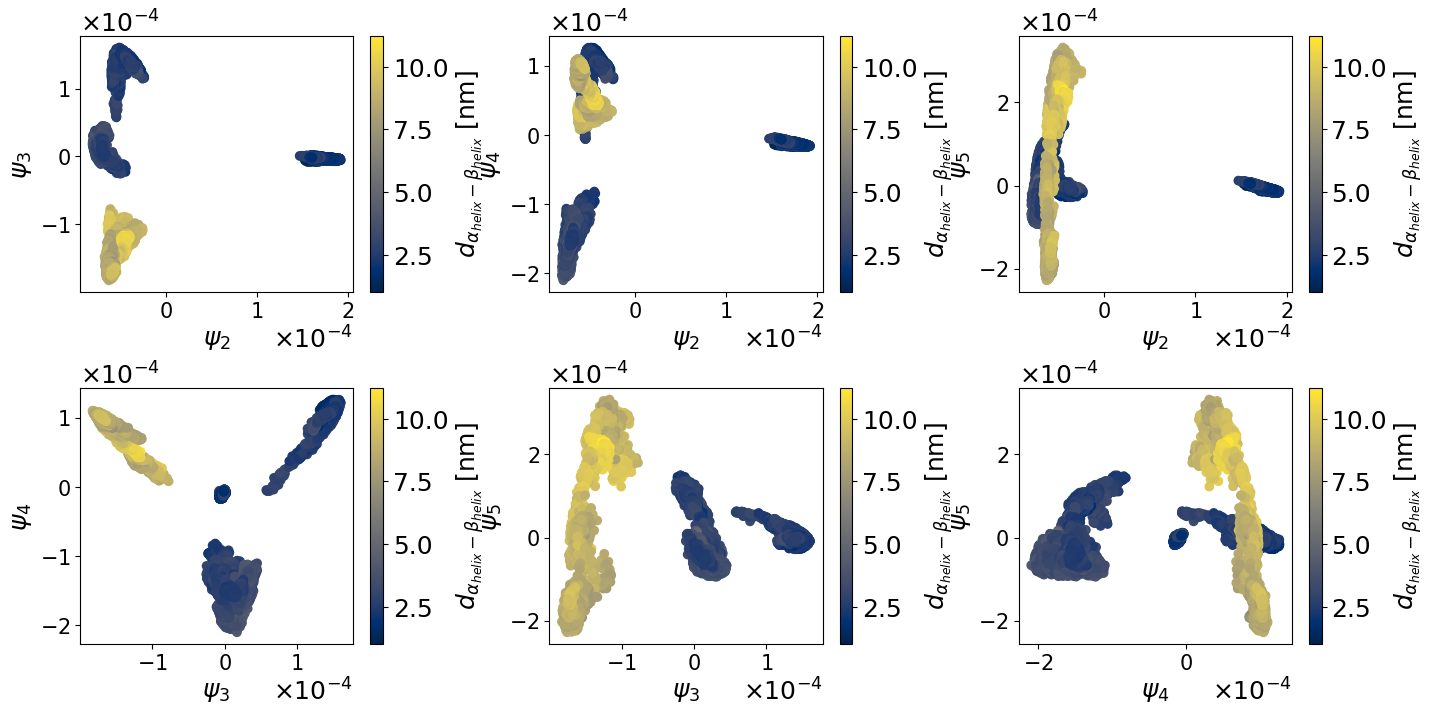

In [16]:
%matplotlib inline

font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

### color 
colors = tail_distances/10
ticks = list(np.arange(colors.min(), colors.max()))
diff_plots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                      skip_lead=True, colorMap=colors, cmap='cividis', 
                      colorbar=True, colorlabel=r'$d_{\alpha_{helix}-\beta_{helix}}$ [nm]', 
                      figSuffix='2d_taildistances_opt1', ticks=None)

#diff_plots.plotmaps(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, cmap='coolwarm', colorbar=True,colorlabel=r'$\alpha_{helix}-\beta_{helix}$ [nm]', skip_3D=False, figSuffix = 'colorby_taildistances_opt1', ticks=None)


nplots_split:3
7


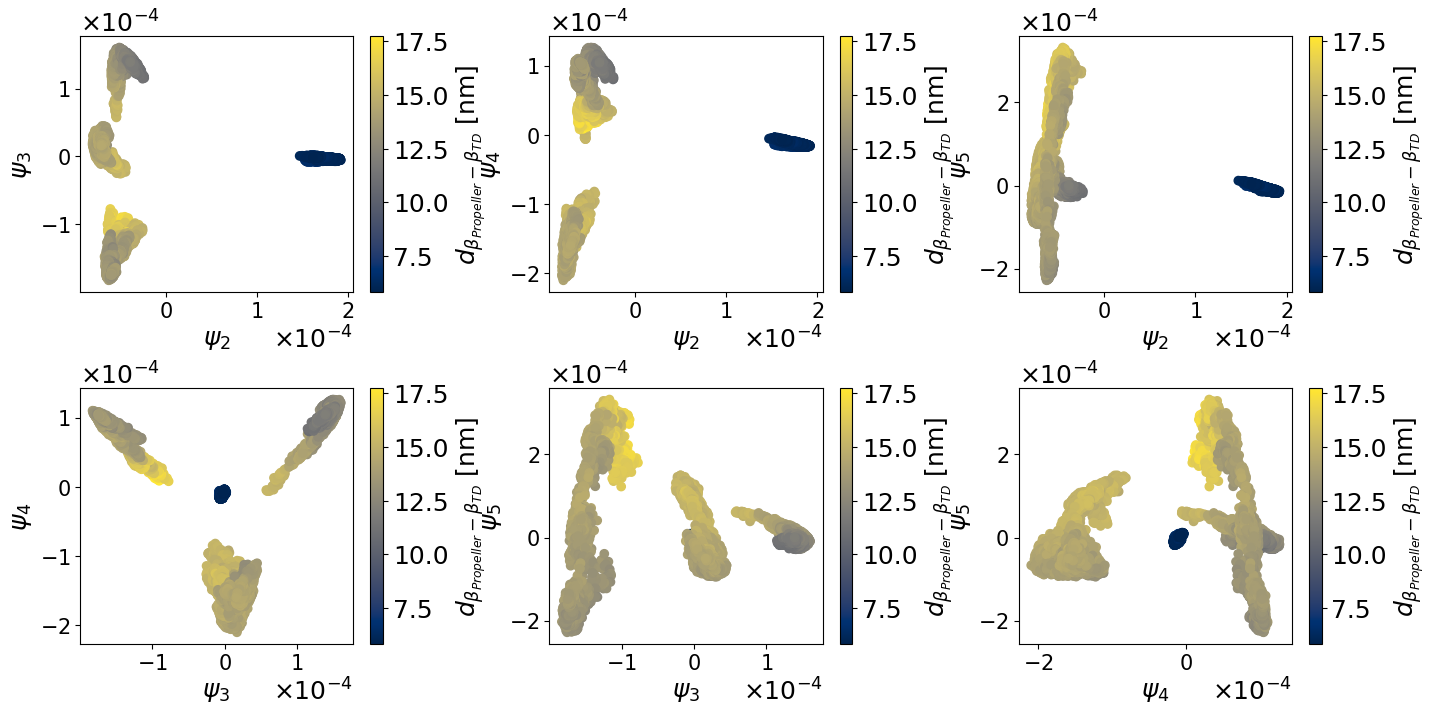

In [17]:
### color 
colors = beta_distances/10
ticks = list(np.arange(colors.min(), colors.max()))
diff_plots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                      skip_lead=True, colorMap=colors, cmap='cividis', 
                      colorbar=True, colorlabel=r'$d_{\beta_{Propeller}-\beta_{TD}}$ [nm]', 
                      figSuffix='2d_beta_distances_opt1', ticks=None)

#diff_plots.plotmaps(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, cmap='coolwarm', colorbar=True,colorlabel=r'$\beta_{Propeller}-\beta_{TD}$ [nm]', skip_3D=False, figSuffix = 'colorby_beta_distances_opt1')


nplots_split:3
7


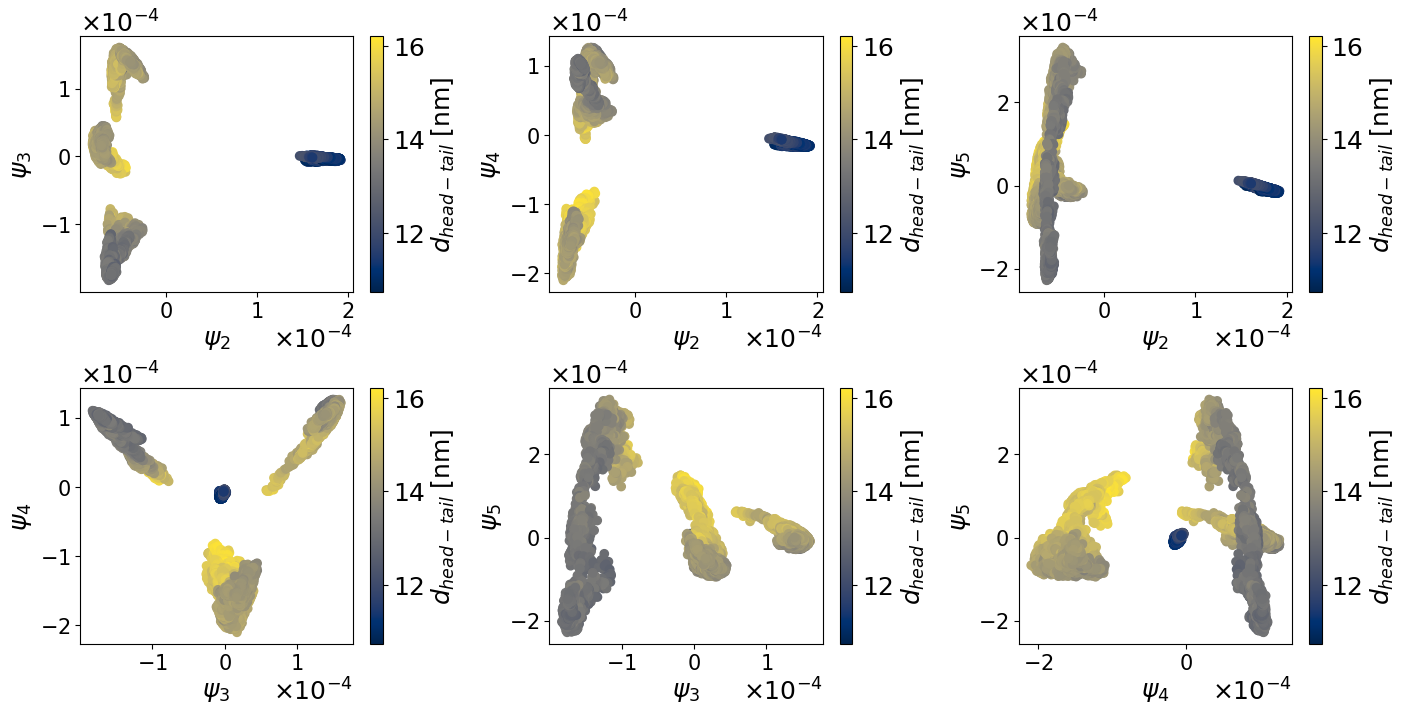

In [18]:
### color 
colors = ht_distances/10
ticks = list(np.arange(colors.min(), colors.max()))
diff_plots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                      skip_lead=True, colorMap=colors, cmap='cividis', 
                      colorbar=True, colorlabel=r'$d_{head-tail}$ [nm]', 
                      figSuffix='2d_ht_distances_opt1', ticks=None)
 
#diff_plots.plotmaps(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, cmap='coolwarm', colorbar=True,colorlabel=r'$head-tail$ [nm]', skip_3D=False, figSuffix = 'colorby_ht_distances_opt1')


nplots_split:3
7


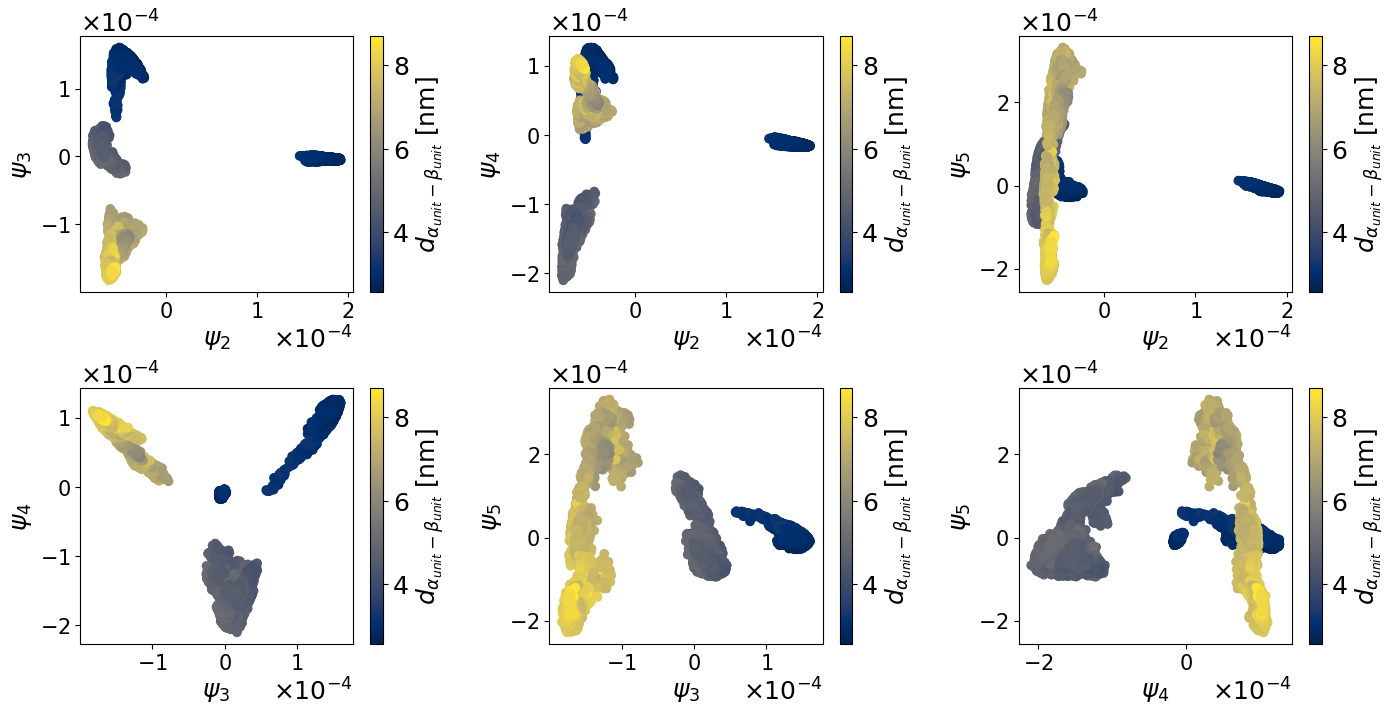

In [19]:
### color 
colors = chain_distances/10
ticks = list(np.arange(colors.min(), colors.max()))
diff_plots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                      skip_lead=True, colorMap=colors, cmap='cividis', 
                      colorbar=True, colorlabel=r'$d_{\alpha_{unit}-\beta_{unit}}$ [nm]', 
                      figSuffix='2d_chain_distances_opt1', ticks=None)

#diff_plots.plotmaps(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, cmap='coolwarm', colorbar=True,colorlabel=r'$\alpha_{unit}-\beta_{unit}$ [nm]', skip_3D=False, figSuffix = 'colorby_chain_distances_opt1')


#### conformational analysis

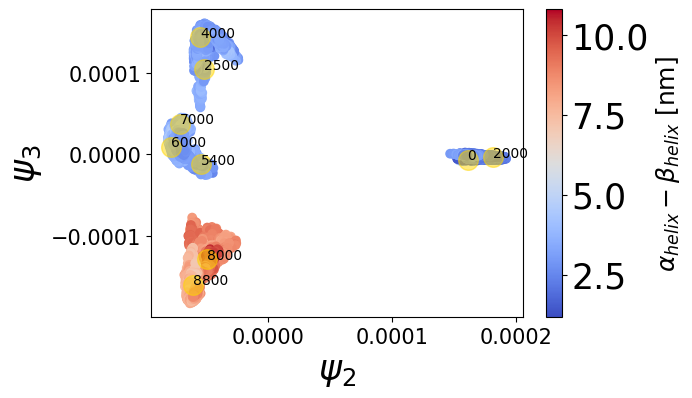

In [110]:
%matplotlib notebook
%matplotlib inline

import mplcursors

def plot3D_interactive(psi, eps, plot_stride=1, select_axis_2d=[1, 2], skip_lead=True, colorMap='blue', cmap='Accent', ticks=[1, 2, 3, 4, 5, 6], colorbar=True, colorlabel='Traj', skip_3D=False, figSuffix=''):

    if skip_lead:
        lead = 1
    else:
        lead = 0
    
    fig = plt.figure(figsize = (6,4))
    ax = fig.add_subplot(111)#, projection='3d')
    
    norm = plt.Normalize()
    color_map = plt.cm.coolwarm(norm(colorMap))
    #for i in range(len(psi)): # plot each point + it's index as text above
    #    x = psi[::plot_stride,lead][i]
    #    y = psi[::plot_stride,lead+1][i]
    #    z = psi[::plot_stride,lead+2][i]
    #    label = i
    #    ax.scatter(x, y, z, color=color_map[i])
    #    ax.text(x, y, z, '%s' % (label), size=5, zorder=1, color='k')
    
    #im = ax.scatter(psi[::plot_stride,lead], psi[::plot_stride,lead+1], psi[::plot_stride,lead+2]) #, c=colorMap, cmap=cmap)
    im = ax.scatter(psi[::plot_stride,lead], psi[::plot_stride,lead+1], c=colorMap, cmap=cmap)
    
    for fr in [0, 2000, 2500, 4000, 5400, 6000, 7000, 8000, 8800]:
        
        ax.scatter(psi[::plot_stride,1:4][fr][0], psi[::plot_stride,1:4][fr][1], marker='o', s=200, color='gold', alpha=.5)
        x = psi[::plot_stride,1:4][fr][0]
        y = psi[::plot_stride,1:4][fr][1]
        label=fr
        ax.text(x, y, '%s' % (label), size=10, zorder=1, color='black')
    
    mplcursors.cursor(ax).connect("add", lambda sel: sel.annotation.set_text(sel.index))
    
    if colorbar:
        if ticks:
            cbar = plt.colorbar(im, ax=ax, ticks=ticks)
        else:
            cbar = plt.colorbar(im, ax=ax)
        #im.set_clim(model_loss_eigen['feat_evecs_SRV_unbiased'][:,ii+1].min(), model_loss_eigen['feat_evecs_SRV_unbiased'][:,ii+1].max())
        cbar.set_label(colorlabel, size=18)
    
    ax.set_xlabel('$\psi$$_{'+str(lead+1)+'}$', labelpad=5)
    ax.set_ylabel('$\psi$$_{'+str(lead+2)+'}$', labelpad=5)
    #ax.set_zlabel('$\psi$$_{'+str(lead+3)+'}$', labelpad=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #ax.set_box_aspect(aspect=(4,4,4), zoom=0.8)
    
    # disable auto rotation
    #ax.zaxis.set_tick_params(labelsize=15)
    #ax.zaxis.set_rotate_label(False)
    
    
    plt.show()
        
    fig.tight_layout()
    fig.savefig('interactive_evecs_'+str(lead+1)+str(lead+2)+str(lead+3)+'_'+str(eps)+ '_' + figSuffix + '.png', dpi=300)
    #plt.close()
        
colors = [np.ones(2000)*1, np.ones(2000)*1, np.ones(2000)*1,
          np.ones(2000)*2, np.ones(2000)*2, np.ones(2000)*2]

colors = tail_distances/10
plot3D_interactive(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, cmap='coolwarm', colorlabel=r'$\alpha_{helix}-\beta_{helix}$ [nm]', colorbar=True, skip_3D=False, figSuffix = 'bytaildist_rotate_opt1', ticks=None)




In [111]:
print(0, 2450, 2450*2, 2450*3, 2450*4)
lframes = [0, 2000, 2500, 4000, 5400, 6000, 7000, 8000, 8800]

#replica 1 [0-2000]
x = [0, 2000]
x1 = [ (i*2)+1 for i in x]
print(x1)

#replica 2 [2000-4000]
x = [2500, 4000]
x2 = [ ( (i-2450)  *2)-1 for i in x]
print(x2)

#replica 3 [4000-6000]
x = [5400, 6000, 7000]
x3 = [ ( (i-2450*2)  *2)-1 for i in x]
print(x3)

#replica 4 [6000-8000]
x = [8000, 8800]
x4 = [ ( (i-2450*3)  *2)-1 for i in x]
print(x4)


0 2450 4900 7350 9800
[1, 4001]
[99, 3099]
[999, 2199, 4199]
[1299, 2899]


In [117]:
import nglview as nv
import seaborn as sns
from time import sleep
import io
from PIL import Image 


view = nv.show_mdanalysis(universe_cg_traj_reps[3])
# set the frame number


# clear representations
view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()



# specify color
view.add_representation('spacefill', selection=list(np.arange(169)), color='blue', radius=5, opacity=0.85)
view.add_representation('spacefill', selection=list(np.arange(169, 300)), color='red', radius=5)

#view.add_representation('spacefill', selection="index 100 to 299", color='red')

#view.component_1.add_surface(opacity=0.3)
#view.download_image()
#view.render_image(factor=6) # higher is better
# need to run below command in different notebook cell
dd=1
frame=x4[dd]


view.frame=frame
#image=view.render_image(frame=frame, factor=4, antialias=True, trim=False, transparent=False)

view

/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:300: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:301: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:302: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))


NGLWidget(frame=2899, max_frame=5171)

In [118]:
img = view.render_image()

In [119]:
fra = lframes[8]
fra

8800

In [120]:
image2 = Image.open(io.BytesIO(img.value))
image2.save(f'figure_integrin_dmap_aa_cg_{fra}.png')

#### Decoder on the net data

In [11]:
#from molgen.models import WGANGP


In [12]:
#m1_trj_list[0]
#import torch

#### align all trajectories

In [85]:
print(0, 2450, 2450*2, 2450*3, 2450*4)


0 2450 4900 7350 9800


In [91]:
aligned_cat_trajs = rmsd_jax.run_align_trajs(cat_trajs[5000], cat_trajs)
aligned_cat_trajs.shape

(9800, 300, 3)

In [92]:
aligned_cat_excl_trajs = rmsd_jax.run_align_trajs(cat_excl_trajs[5000], cat_excl_trajs)
aligned_cat_excl_trajs.shape

(9800, 300, 3)

In [94]:
#### save aligned catenated trajectory

with open(r"integrin_aa_cg_300_original_aligned_2450_pertraj.pkl", "wb") as f:
        pickle.dump({'cat_trajs': np.array(cat_trajs),
                     'aligned_cat_trajs': np.array(aligned_cat_trajs),
                     'aligned_cat_excl_trajs': np.array(aligned_cat_excl_trajs)}, f)
        

In [15]:
aligned_cat_trajs = np.array(aligned_cat_trajs)

In [16]:
cat_trajs.shape

(9800, 300, 3)

In [17]:
aligned_cat_trajs.shape

(9800, 300, 3)

In [26]:
### create a universe for CG model [from example in MDAnalysis]

n_residues = 300
n_atoms = n_residues

# create resindex list
resindices = np.arange(n_residues)

# all water molecules belong to 1 segment
segindices = [0] * n_residues

# create the Universe
f_cg_1_universe = mda.Universe.empty(n_atoms,
                                 n_residues=n_residues,
                                 atom_resindex=resindices,
                                 residue_segindex=segindices,
                                 trajectory=True) # necessary for adding coordinates




### topology attributes
from MDAnalysis.coordinates.memory import MemoryReader

f_cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
f_cg_1_universe.add_TopologyAttr('segid', ['INT'])



In [27]:

#### frame 0 positions

f_cg_1_universe.atoms.positions = cat_trajs[0]
f_cg_1_universe.load_new(np.array(cat_trajs), format=MemoryReader)


view = nv.show_mdanalysis(f_cg_1_universe)

# clear representations
#view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=2.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=2.5, opacity=0.85)
view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=9799)

In [28]:

#### frame 0 positions

f_cg_1_universe.atoms.positions = aligned_cat_trajs[0]
f_cg_1_universe.load_new(np.array(aligned_cat_trajs), format=MemoryReader)


view = nv.show_mdanalysis(f_cg_1_universe)

# clear representations
#view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=2.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=2.5, opacity=0.85)
view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=9799)